In [3]:
# Cell 1: Imports and global style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import json
import networkx as nx
from networkx.readwrite import json_graph

# Global seaborn style
sns.set_theme(style="white", context="talk")

In [4]:
# Cell 2: Load Harry Potter networks (HP2, HP3)
with open("HP2.json", "r", encoding="utf-8") as f:
    hp2_data = json.load(f)
with open("HP3.json", "r", encoding="utf-8") as f:
    hp3_data = json.load(f)

HP2 = json_graph.node_link_graph(
    hp2_data,
    directed=hp2_data.get("directed", False),
    multigraph=hp2_data.get("multigraph", False),
    edges="links",
)

HP3 = json_graph.node_link_graph(
    hp3_data,
    directed=hp3_data.get("directed", False),
    multigraph=hp3_data.get("multigraph", False),
    edges="links",
)

print("HP2:", HP2.number_of_nodes(), "nodes,", HP2.number_of_edges(), "edges")
print("HP3:", HP3.number_of_nodes(), "nodes,", HP3.number_of_edges(), "edges")


HP2: 64 nodes, 91 edges
HP3: 64 nodes, 87 edges


In [5]:
# Cell 3: Quick basic stats function for any directed graph
def basic_stats(G, name="G"):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    density = nx.density(G)
    avg_out_degree = m / n if n > 0 else np.nan

    print(f"=== {name} ===")
    print(f"Nodes: {n}")
    print(f"Edges: {m}")
    print(f"Density: {density:.4f}")
    print(f"Average out-degree: {avg_out_degree:.2f}")

    if isinstance(G, nx.DiGraph):
        rec = nx.reciprocity(G)
        print(f"Reciprocity: {rec:.4f}")

    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    print(f"Largest weakly connected component size: {len(largest_wcc)}")
    print()

basic_stats(HP2, "HP2")
basic_stats(HP3, "HP3")


=== HP2 ===
Nodes: 64
Edges: 91
Density: 0.0226
Average out-degree: 1.42
Reciprocity: 0.7912
Largest weakly connected component size: 18

=== HP3 ===
Nodes: 64
Edges: 87
Density: 0.0216
Average out-degree: 1.36
Reciprocity: 0.8046
Largest weakly connected component size: 17



In [6]:
# Cell 4: Load Czech data and build classroom networks
rel_path  = "relational data.xlsx"
attr_path = "student attributes.xlsx"

# Student attributes: two-row header -> use the second row as variable names
attr_raw = pd.read_excel(attr_path, header=[0, 1])
attr_raw.columns = [c[1] if isinstance(c, tuple) else c for c in attr_raw.columns]
attributes = attr_raw

# Node attribute fields to attach to the graphs
attr_fields = [
    "gender",
    "HISEI",
    "whole_classroom_talk_start",
    "whole_classroom_talk_end",
    "literacy_start",
    "literacy_end",
    "need_of_success",
    "avoidance_of_failure",
]

rel_xls = pd.ExcelFile(rel_path)
print("Sheets in relational data:", rel_xls.sheet_names)

graphs_cz = {}

for sheet in rel_xls.sheet_names:
    print(f"\nProcessing sheet: {sheet}")
    df = pd.read_excel(rel_path, sheet_name=sheet, index_col=0)
    df = df.fillna(0)

    # Row labels are 101,102,...; columns are "0101","0102",... etc.
    # Convert both to integer student IDs and keep the common intersection.
    df.index = pd.to_numeric(df.index, errors="coerce")
    df.columns = pd.to_numeric(df.columns, errors="coerce")

    df = df.loc[df.index.notna(), df.columns[df.columns.notna()]]
    df.index = df.index.astype(int)
    df.columns = df.columns.astype(int)

    common_ids = sorted(set(df.index) & set(df.columns))
    df = df.loc[common_ids, common_ids]

    # Binarize nominations: >0 means a directed tie
    df_bin = (df > 0).astype(int)

    G = nx.from_pandas_adjacency(df_bin, create_using=nx.DiGraph)

    # Attach node attributes
    for node in list(G.nodes()):
        sid = int(node)
        G.nodes[node]["studentID"] = sid

        matched = attributes.loc[attributes["studentID"] == sid]
        if len(matched) >= 1:
            row = matched.iloc[0]
            for col in attr_fields:
                if col in row.index:
                    G.nodes[node][col] = row[col]

    graphs_cz[sheet] = G
    print(f"  nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

print("\nAll Czech classroom graphs created.")
print("Available graphs:", list(graphs_cz.keys()))

# Use 01start and 01end as the main Czech networks for comparison
G_cz_start = graphs_cz["01start"]
G_cz_end   = graphs_cz["01end"]

print(f"\nCzech 01start: {G_cz_start.number_of_nodes()} nodes, {G_cz_start.number_of_edges()} edges")
print(f"Czech 01end:   {G_cz_end.number_of_nodes()} nodes, {G_cz_end.number_of_edges()} edges")


Sheets in relational data: ['01start', '01end', '02start', '02end', '03start', '03end', '04start', '04end', '05start', '05end', '06start', '06end', '07start', '07end', '08start', '08end', '09start', '09end', '10start', '10end', '11start', '11end', '12start', '12end']

Processing sheet: 01start
  nodes: 24, edges: 208

Processing sheet: 01end
  nodes: 24, edges: 237

Processing sheet: 02start
  nodes: 26, edges: 214

Processing sheet: 02end
  nodes: 26, edges: 215

Processing sheet: 03start
  nodes: 23, edges: 142

Processing sheet: 03end
  nodes: 23, edges: 154

Processing sheet: 04start
  nodes: 24, edges: 218

Processing sheet: 04end
  nodes: 24, edges: 240

Processing sheet: 05start
  nodes: 26, edges: 184

Processing sheet: 05end
  nodes: 26, edges: 212

Processing sheet: 06start
  nodes: 22, edges: 163

Processing sheet: 06end
  nodes: 22, edges: 156

Processing sheet: 07start
  nodes: 22, edges: 87

Processing sheet: 07end
  nodes: 22, edges: 88

Processing sheet: 08start
  nodes

HP3 core network: 17 nodes, 87 edges


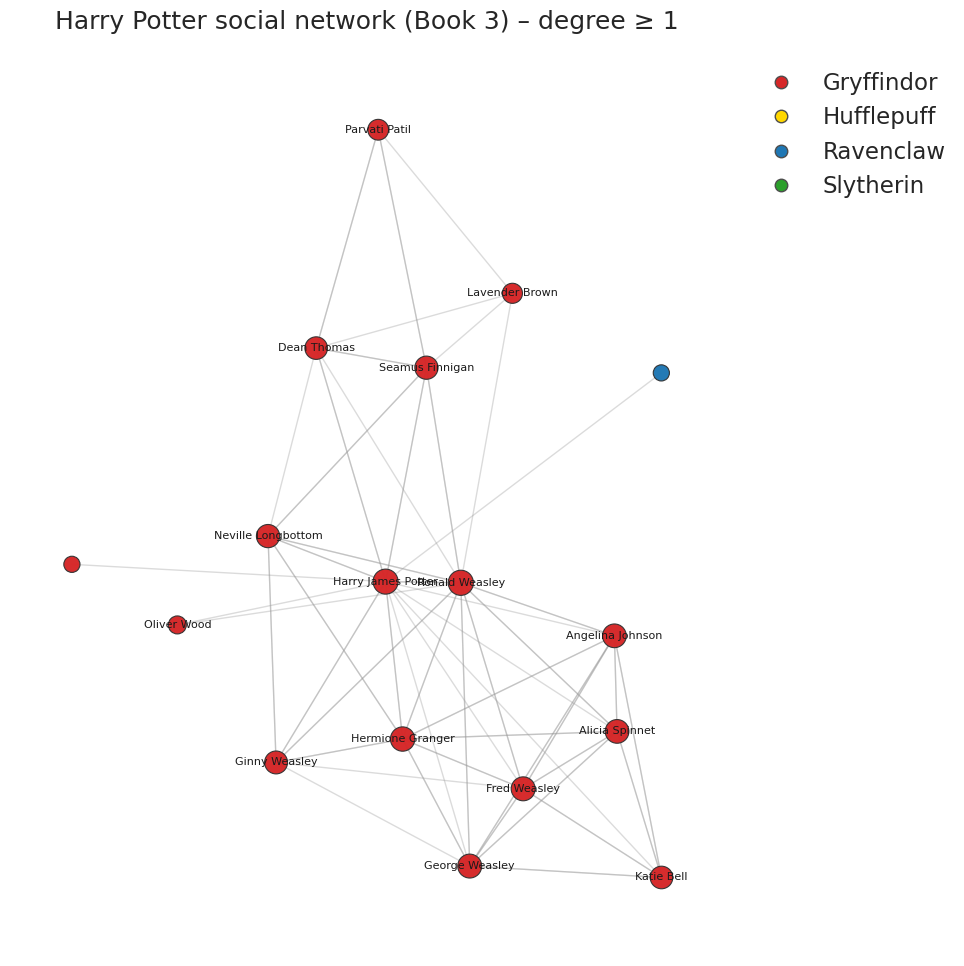

In [7]:
# Cell 5: Visualize HP3 core network (degree >= 1)
deg_all_hp3 = dict(HP3.degree())
core_nodes_hp3 = [v for v, d in deg_all_hp3.items() if d >= 1]

HP3_core = HP3.subgraph(core_nodes_hp3).copy()
print(f"HP3 core network: {HP3_core.number_of_nodes()} nodes, {HP3_core.number_of_edges()} edges")

plt.figure(figsize=(10, 10))

# House color map
color_map_scheme = {
    "1": "tab:red",   # Gryffindor
    "2": "gold",      # Hufflepuff
    "3": "tab:blue",  # Ravenclaw
    "4": "tab:green", # Slytherin
}

houses_core = nx.get_node_attributes(HP3_core, "house")
deg_core = dict(HP3_core.degree())

scale_core = 80
node_colors_core = [
    color_map_scheme.get(houses_core.get(v), "lightgrey")
    for v in HP3_core.nodes()
]
node_sizes_core = [
    80 + scale_core * np.log1p(deg_core[v])
    for v in HP3_core.nodes()
]

pos_core = nx.kamada_kawai_layout(HP3_core)

nx.draw_networkx_edges(
    HP3_core, pos_core,
    alpha=0.35,
    width=1.0,
    edge_color="0.6",
    arrows=False,
)

nx.draw_networkx_nodes(
    HP3_core, pos_core,
    node_color=node_colors_core,
    node_size=node_sizes_core,
    linewidths=0.8,
    edgecolors="0.2",
    alpha=0.98,
)

labels_core = {
    v: HP3_core.nodes[v].get("name", str(v))
    for v, d in deg_core.items() if d >= 2
}
nx.draw_networkx_labels(
    HP3_core, pos_core,
    labels=labels_core,
    font_size=8,
)

legend_elements = [
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:red", markeredgecolor="0.3",
           label="Gryffindor"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="gold", markeredgecolor="0.3",
           label="Hufflepuff"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:blue", markeredgecolor="0.3",
           label="Ravenclaw"),
    Line2D([0], [0], marker="o", linestyle="",
           markerfacecolor="tab:green", markeredgecolor="0.3",
           label="Slytherin"),
]

plt.legend(
    handles=legend_elements,
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
)

plt.title("Harry Potter social network (Book 3) – degree ≥ 1", pad=16)
plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# Cell 6: Global structural statistics and change over time
def graph_summary(G, name, directed=True):
    n = G.number_of_nodes()
    m = G.number_of_edges()

    if directed and isinstance(G, nx.DiGraph):
        density = nx.density(G)
        reciprocity = nx.reciprocity(G)
        G_und = G.to_undirected()
    else:
        density = nx.density(G)
        reciprocity = np.nan
        G_und = G

    transitivity = nx.transitivity(G_und)
    avg_clustering = nx.average_clustering(G_und)

    if nx.is_connected(G_und):
        avg_path_len = nx.average_shortest_path_length(G_und)
    else:
        gcc_nodes = max(nx.connected_components(G_und), key=len)
        avg_path_len = nx.average_shortest_path_length(G_und.subgraph(gcc_nodes))

    return pd.DataFrame([{
        "name": name,
        "n_nodes": n,
        "n_edges": m,
        "density": density,
        "reciprocity": reciprocity,
        "transitivity": transitivity,
        "avg_clustering": avg_clustering,
        "avg_path_len_gcc": avg_path_len,
    }])

df_stats = pd.concat(
    [
        graph_summary(HP2, "HP2", directed=True),
        graph_summary(HP3, "HP3", directed=True),
        graph_summary(G_cz_start, "Czech_01start", directed=True),
        graph_summary(G_cz_end,   "Czech_01end",   directed=True),
    ],
    ignore_index=True,
)
df_stats

,name,n_nodes,n_edges,density,reciprocity,transitivity,avg_clustering,avg_path_len_gcc
0,HP2,64,91,0.022569,0.791209,0.640288,0.199845,1.647059
1,HP3,64,87,0.021577,0.804598,0.636364,0.184546,1.713235
2,Czech_01start,24,208,0.376812,0.673077,0.661432,0.725801,1.503623
3,Czech_01end,24,237,0.429348,0.767932,0.711697,0.791795,1.478261


In [9]:
# Cell 7: Structural change between t1 and t2 (HP vs Czech)
def structural_change(G_start, G_end, label):
    s1 = graph_summary(G_start, label + "_start", directed=True).iloc[0]
    s2 = graph_summary(G_end,   label + "_end",   directed=True).iloc[0]
    return pd.DataFrame([{
        "pair": label,
        "delta_density":         s2["density"]      - s1["density"],
        "delta_reciprocity":     s2["reciprocity"]  - s1["reciprocity"],
        "delta_transitivity":    s2["transitivity"] - s1["transitivity"],
        "delta_avg_clustering":  s2["avg_clustering"] - s1["avg_clustering"],
    }])

df_struct_change = pd.concat(
    [
        structural_change(HP2, HP3, "HP"),
        structural_change(G_cz_start, G_cz_end, "Czech_01"),
    ],
    ignore_index=True,
)
df_struct_change


,pair,delta_density,delta_reciprocity,delta_transitivity,delta_avg_clustering
0,HP,-0.000992,0.013389,-0.003924,-0.015299
1,Czech_01,0.052536,0.094856,0.050265,0.065993


In [10]:
# Cell 8: Node-level measures for all four networks
def node_level_measures(G, name, directed=True):
    if directed and isinstance(G, nx.DiGraph):
        indeg = dict(G.in_degree())
        outdeg = dict(G.out_degree())
        deg = dict(G.degree())
        G_und = G.to_undirected()
    else:
        deg = dict(G.degree())
        indeg = {v: np.nan for v in G.nodes()}
        outdeg = {v: np.nan for v in G.nodes()}
        G_und = G

    # Use the largest connected component for betweenness and eigenvector
    gcc_nodes = max(nx.connected_components(G_und), key=len)
    G_gcc = G_und.subgraph(gcc_nodes)

    betw = nx.betweenness_centrality(G_gcc, normalized=True)
    eig = nx.eigenvector_centrality_numpy(G_gcc)

    rows = []
    for v in G.nodes():
        attrs = G.nodes[v]
        row = {
            "graph": name,
            "node": v,
            "name": attrs.get("name", v),
            "degree": deg[v],
            "indegree": indeg[v],
            "outdegree": outdeg[v],
            "betweenness": betw.get(v, 0.0),
            "eigenvector": eig.get(v, 0.0),
            "house": attrs.get("house", None),
            "gender": attrs.get("gender", None),
            "schoolyear": attrs.get("schoolyear", None),
        }
        # Czech-specific attributes if present
        for extra in [
            "HISEI",
            "whole_classroom_talk_end",
            "literacy_end",
            "need_of_success",
            "avoidance_of_failure",
        ]:
            if extra in attrs:
                row[extra] = attrs[extra]
        rows.append(row)
    return pd.DataFrame(rows)

df_nodes_hp2 = node_level_measures(HP2, "HP2", directed=True)
df_nodes_hp3 = node_level_measures(HP3, "HP3", directed=True)
df_nodes_cz_start = node_level_measures(G_cz_start, "Czech_01start", directed=True)
df_nodes_cz_end   = node_level_measures(G_cz_end,   "Czech_01end",   directed=True)

df_nodes_all = pd.concat(
    [df_nodes_hp2, df_nodes_hp3, df_nodes_cz_start, df_nodes_cz_end],
    ignore_index=True,
)
df_nodes_all.head()


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,house,gender,schoolyear,HISEI,whole_classroom_talk_end,literacy_end,need_of_success,avoidance_of_failure
0,HP2,1,Adrian Pucey,0,0,0,0.000000,0.000000,4,1,1989,NaN,NaN,NaN,NaN,NaN
1,HP2,2,Alicia Spinnet,15,7,8,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN
2,HP2,3,Angelina Johnson,13,7,6,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN
3,HP2,4,Anthony Goldstein,0,0,0,0.000000,0.000000,3,1,1991,NaN,NaN,NaN,NaN,NaN
4,HP2,5,Blaise Zabini,0,0,0,0.000000,0.000000,4,1,1991,NaN,NaN,NaN,NaN,NaN


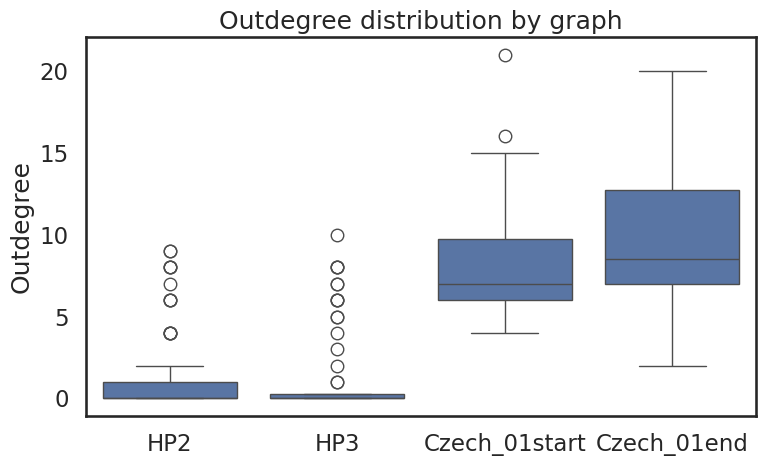

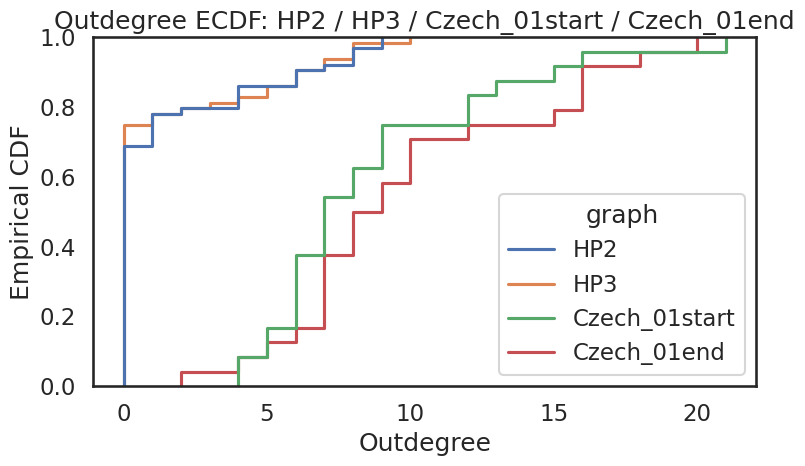

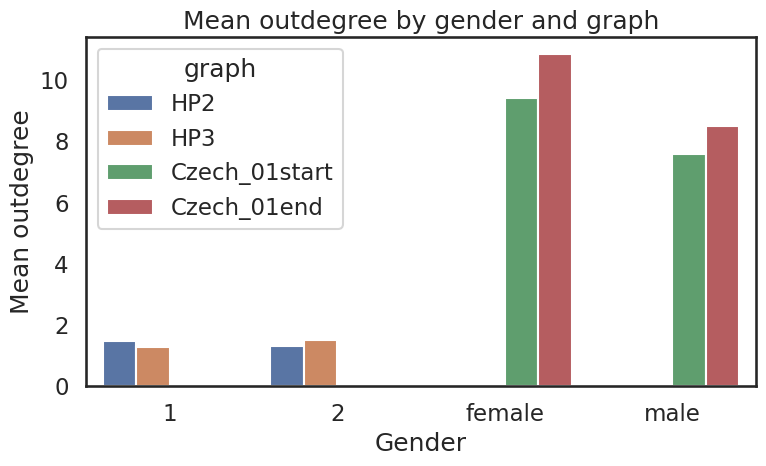

In [11]:
# Cell 9: Outdegree distributions and gender differences
# 9a. Outdegree distribution by graph (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_nodes_all,
    x="graph",
    y="outdegree",
)
plt.xlabel("")
plt.ylabel("Outdegree")
plt.title("Outdegree distribution by graph")
plt.tight_layout()
plt.show()

# 9b. Outdegree ECDF by graph
plt.figure(figsize=(8, 5))
sns.ecdfplot(
    data=df_nodes_all,
    x="outdegree",
    hue="graph",
)
plt.xlabel("Outdegree")
plt.ylabel("Empirical CDF")
plt.title("Outdegree ECDF: HP2 / HP3 / Czech_01start / Czech_01end")
plt.tight_layout()
plt.show()

# 9c. Mean outdegree by gender and graph
def mean_outdeg_by_gender(df_nodes, graph_name):
    sub = df_nodes[df_nodes["graph"] == graph_name]
    return (
        sub.groupby("gender")["outdegree"]
        .agg(["count", "mean", "std"])
        .reset_index()
        .assign(graph=graph_name)
    )

df_gender_hp2 = mean_outdeg_by_gender(df_nodes_all, "HP2")
df_gender_hp3 = mean_outdeg_by_gender(df_nodes_all, "HP3")
df_gender_cz_start = mean_outdeg_by_gender(df_nodes_all, "Czech_01start")
df_gender_cz_end   = mean_outdeg_by_gender(df_nodes_all, "Czech_01end")

df_gender = pd.concat(
    [df_gender_hp2, df_gender_hp3, df_gender_cz_start, df_gender_cz_end],
    ignore_index=True,
)

df_gender_plot = df_gender.dropna(subset=["gender"]).copy()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_gender_plot,
    x="gender",
    y="mean",
    hue="graph",
)
plt.ylabel("Mean outdegree")
plt.xlabel("Gender")
plt.title("Mean outdegree by gender and graph")
plt.tight_layout()
plt.show()


In [12]:
# === Cell 10: Assortativity (homophily) by attribute ===
def assortativity_by_attr(G, attr, directed=True):
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G
    nodes_with_attr = [v for v in H.nodes() if attr in H.nodes[v]]
    H = H.subgraph(nodes_with_attr).copy()
    if H.number_of_edges() == 0:
        return np.nan
    return nx.attribute_assortativity_coefficient(H, attr)

assort_hp2_house = assortativity_by_attr(HP2, "house", directed=True)
assort_hp3_house = assortativity_by_attr(HP3, "house", directed=True)
assort_hp2_gender = assortativity_by_attr(HP2, "gender", directed=True)
assort_hp3_gender = assortativity_by_attr(HP3, "gender", directed=True)
assort_hp2_year   = assortativity_by_attr(HP2, "schoolyear", directed=True)
assort_hp3_year   = assortativity_by_attr(HP3, "schoolyear", directed=True)

assort_cz_start_gender = assortativity_by_attr(G_cz_start, "gender", directed=True)
assort_cz_end_gender   = assortativity_by_attr(G_cz_end,   "gender", directed=True)

df_assort = pd.DataFrame(
    [
        {"graph": "HP2",          "attr": "house",      "assortativity": assort_hp2_house},
        {"graph": "HP3",          "attr": "house",      "assortativity": assort_hp3_house},
        {"graph": "HP2",          "attr": "gender",     "assortativity": assort_hp2_gender},
        {"graph": "HP3",          "attr": "gender",     "assortativity": assort_hp3_gender},
        {"graph": "HP2",          "attr": "schoolyear", "assortativity": assort_hp2_year},
        {"graph": "HP3",          "attr": "schoolyear", "assortativity": assort_hp3_year},
        {"graph": "Czech_01start","attr": "gender",     "assortativity": assort_cz_start_gender},
        {"graph": "Czech_01end",  "attr": "gender",     "assortativity": assort_cz_end_gender},
    ]
)
df_assort


,graph,attr,assortativity
0,HP2,house,0.378531
1,HP3,house,-0.009709
2,HP2,gender,0.036190
3,HP3,gender,-0.087108
4,HP2,schoolyear,0.098822
5,HP3,schoolyear,0.116147
6,Czech_01start,gender,0.343693
7,Czech_01end,gender,0.341254


In [13]:
# Cell 11: Mixing summary (observed vs expected homophily)
def mixing_summary(G, attr, directed=True):
    """
    Return mixing matrix, observed same-type edge fraction, expected same-type
    fraction under random mixing with same attribute distribution, and their ratio.
    """
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G

    keep = [v for v in H.nodes() if attr in H.nodes[v]]
    H = H.subgraph(keep).copy()
    if H.number_of_edges() == 0:
        return None

    mix = nx.attribute_mixing_matrix(H, attr, normalized=True)
    same_frac = np.trace(mix)

    values = [H.nodes[v][attr] for v in H.nodes()]
    vc = pd.Series(values).value_counts(normalize=True)
    expected_same_frac = (vc ** 2).sum()

    ratio = same_frac / expected_same_frac if expected_same_frac > 0 else np.nan
    return mix, same_frac, expected_same_frac, ratio

# HP: house / gender / schoolyear
mix_hp2_house = mixing_summary(HP2, "house", directed=True)
mix_hp3_house = mixing_summary(HP3, "house", directed=True)
mix_hp2_gender = mixing_summary(HP2, "gender", directed=True)
mix_hp3_gender = mixing_summary(HP3, "gender", directed=True)

# Czech: gender
mix_cz_start_gender = mixing_summary(G_cz_start, "gender", directed=True)
mix_cz_end_gender   = mixing_summary(G_cz_end,   "gender", directed=True)

def summarize_mixing(label, attr, result):
    if result is None:
        return None
    mix, same_frac, exp_same, ratio = result
    return {
        "graph": label,
        "attr": attr,
        "same_fraction": same_frac,
        "expected_same_fraction": exp_same,
        "ratio_obs_over_expected": ratio,
    }

rows = []
rows.append(summarize_mixing("HP2", "house", mix_hp2_house))
rows.append(summarize_mixing("HP3", "house", mix_hp3_house))
rows.append(summarize_mixing("HP2", "gender", mix_hp2_gender))
rows.append(summarize_mixing("HP3", "gender", mix_hp3_gender))
rows.append(summarize_mixing("Czech_01start", "gender", mix_cz_start_gender))
rows.append(summarize_mixing("Czech_01end",   "gender", mix_cz_end_gender))

df_mixing_summary = pd.DataFrame([r for r in rows if r is not None])
df_mixing_summary


,graph,attr,same_fraction,expected_same_fraction,ratio_obs_over_expected
0,HP2,house,0.945455,0.278320,3.397002
1,HP3,house,0.980769,0.278320,3.523887
2,HP2,gender,0.581818,0.539551,1.078338
3,HP3,gender,0.480769,0.539551,0.891055
4,Czech_01start,gender,0.688406,0.513889,1.339600
5,Czech_01end,gender,0.691781,0.513889,1.346168


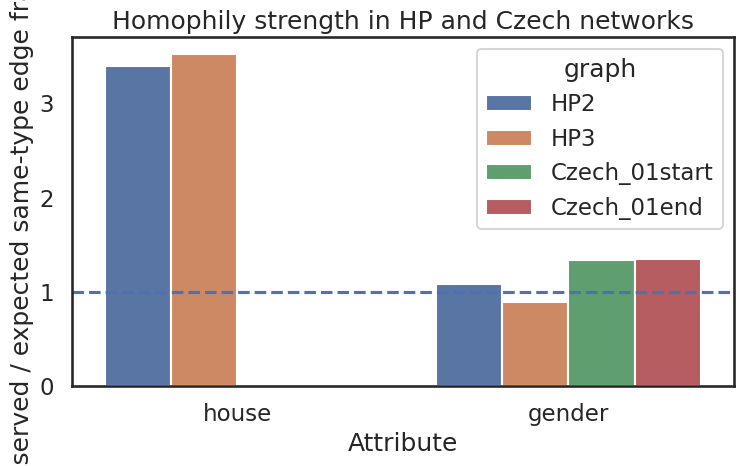

In [14]:
# Cell 12: Plot homophily strength (observed / expected)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_mixing_summary,
    x="attr",
    y="ratio_obs_over_expected",
    hue="graph",
)
plt.axhline(1.0, linestyle="--")
plt.ylabel("Observed / expected same-type edge fraction")
plt.xlabel("Attribute")
plt.title("Homophily strength in HP and Czech networks")
plt.tight_layout()
plt.show()


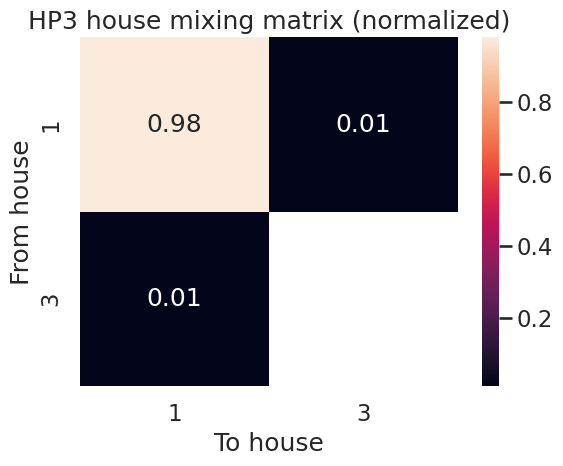

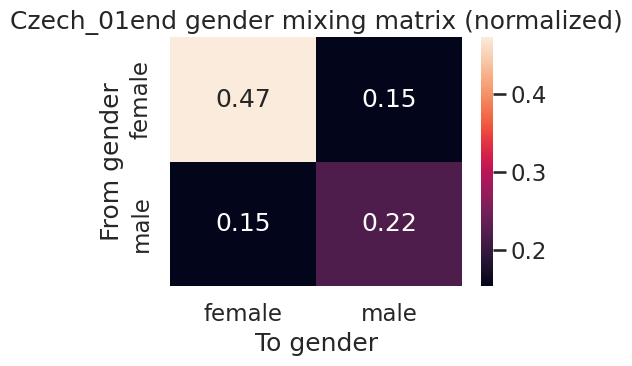

In [15]:
# === Cell 13: Mixing matrix heatmaps (HP3 house, Czech_01end gender) ===
# HP3: house mixing
H_hp3 = HP3.to_undirected()
keep_hp3 = [v for v in H_hp3.nodes() if "house" in H_hp3.nodes[v]]
H_hp3 = H_hp3.subgraph(keep_hp3).copy()

mix_dict_hp3 = nx.attribute_mixing_dict(H_hp3, "house", normalized=True)
labels_house = sorted(mix_dict_hp3.keys())
mix_mat_hp3 = pd.DataFrame(mix_dict_hp3).reindex(
    index=labels_house, columns=labels_house
)

plt.figure(figsize=(6, 5))
sns.heatmap(
    mix_mat_hp3,
    annot=True,
    fmt=".2f",
)
plt.xlabel("To house")
plt.ylabel("From house")
plt.title("HP3 house mixing matrix (normalized)")
plt.tight_layout()
plt.show()

# Czech_01end: gender mixing
H_cz = G_cz_end.to_undirected()
keep_cz = [v for v in H_cz.nodes() if "gender" in H_cz.nodes[v]]
H_cz = H_cz.subgraph(keep_cz).copy()

mix_dict_cz = nx.attribute_mixing_dict(H_cz, "gender", normalized=True)
labels_gender = sorted(mix_dict_cz.keys())
mix_mat_cz = pd.DataFrame(mix_dict_cz).reindex(
    index=labels_gender, columns=labels_gender
)

plt.figure(figsize=(5, 4))
sns.heatmap(
    mix_mat_cz,
    annot=True,
    fmt=".2f",
)
plt.xlabel("To gender")
plt.ylabel("From gender")
plt.title("Czech_01end gender mixing matrix (normalized)")
plt.tight_layout()
plt.show()


In [16]:
# Cell 14: Structural holes and bridging centrality
def add_structural_hole_measures(G, df_nodes, graph_name, directed=True):
    """
    For a given graph, compute:
      - k-core index
      - bridging coefficient
      - bridging centrality (bridging coefficient * betweenness)
    and add them to df_nodes for rows with graph == graph_name.
    """
    if directed and isinstance(G, nx.DiGraph):
        H = G.to_undirected()
    else:
        H = G

    core_num = nx.core_number(H)

    sub = df_nodes[df_nodes["graph"] == graph_name]
    if "betweenness" in sub.columns and sub["betweenness"].notna().any():
        betw_dict = dict(zip(sub["node"], sub["betweenness"]))
    else:
        betw_dict = nx.betweenness_centrality(H, normalized=True)

    deg = dict(H.degree())
    neighbors = {v: set(H.neighbors(v)) for v in H.nodes()}

    bridging_coeff = {}
    bridging_centrality = {}

    for v in H.nodes():
        k_v = deg.get(v, 0)
        if k_v == 0:
            bridging_coeff[v] = 0.0
            bridging_centrality[v] = 0.0
            continue
        neigh = neighbors[v]
        if not neigh:
            bridging_coeff[v] = 0.0
            bridging_centrality[v] = 0.0
            continue
        denom = sum(1.0 / deg.get(u, 1) for u in neigh)
        bc = (1.0 / k_v) / denom if denom > 0 else 0.0
        bridging_coeff[v] = bc
        bridging_centrality[v] = bc * betw_dict.get(v, 0.0)

    df_nodes2 = df_nodes.copy()
    mask = df_nodes2["graph"] == graph_name
    df_nodes2.loc[mask, "kcore"] = df_nodes2.loc[mask, "node"].map(core_num)
    df_nodes2.loc[mask, "bridging_coeff"] = df_nodes2.loc[mask, "node"].map(bridging_coeff)
    df_nodes2.loc[mask, "bridging_centrality"] = df_nodes2.loc[mask, "node"].map(bridging_centrality)

    return df_nodes2

df_nodes_all = add_structural_hole_measures(HP2,        df_nodes_all, "HP2",           directed=True)
df_nodes_all = add_structural_hole_measures(HP3,        df_nodes_all, "HP3",           directed=True)
df_nodes_all = add_structural_hole_measures(G_cz_start, df_nodes_all, "Czech_01start", directed=True)
df_nodes_all = add_structural_hole_measures(G_cz_end,   df_nodes_all, "Czech_01end",   directed=True)

df_nodes_all.head()


,graph,node,name,degree,indegree,outdegree,betweenness,eigenvector,house,gender,schoolyear,HISEI,whole_classroom_talk_end,literacy_end,need_of_success,avoidance_of_failure,kcore,bridging_coeff,bridging_centrality
0,HP2,1,Adrian Pucey,0,0,0,0.000000,0.000000,4,1,1989,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000
1,HP2,2,Alicia Spinnet,15,7,8,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN,7.0,0.137715,0.000338
2,HP2,3,Angelina Johnson,13,7,6,0.002451,0.309742,1,2,1989,NaN,NaN,NaN,NaN,NaN,7.0,0.137715,0.000338
3,HP2,4,Anthony Goldstein,0,0,0,0.000000,0.000000,3,1,1991,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000
4,HP2,5,Blaise Zabini,0,0,0,0.000000,0.000000,4,1,1991,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000


In [17]:
# Cell 15: Top bridging nodes (structural holes)
def top_bridgers(df_nodes, graph_name, k=10):
    sub = df_nodes[df_nodes["graph"] == graph_name].copy()
    return sub.sort_values("bridging_centrality", ascending=False)[
        [
            "name",
            "house",
            "gender",
            "schoolyear",
            "degree",
            "betweenness",
            "kcore",
            "bridging_coeff",
            "bridging_centrality",
        ]
    ].head(k)

print("HP2 top bridging nodes:")
display(top_bridgers(df_nodes_all, "HP2", k=10))

print("HP3 top bridging nodes:")
display(top_bridgers(df_nodes_all, "HP3", k=10))

print("Czech_01start top bridging students:")
display(top_bridgers(df_nodes_all, "Czech_01start", k=10))

print("Czech_01end top bridging students:")
display(top_bridgers(df_nodes_all, "Czech_01end", k=10))


HP2 top bridging nodes:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
24,Harry James Potter,1,1,1991,24,0.586397,7.0,0.010129,0.005940
55,Ronald Weasley,1,1,1991,17,0.104779,6.0,0.045697,0.004788
20,Ginny Weasley,1,2,1992,4,0.003676,2.0,0.513032,0.001886
19,George Weasley,1,1,1989,17,0.012868,7.0,0.094840,0.001220
18,Fred Weasley,1,1,1989,17,0.012868,7.0,0.094840,0.001220
1,Alicia Spinnet,1,2,1989,15,0.002451,7.0,0.137715,0.000338
25,Hermione Granger,1,2,1991,13,0.002451,7.0,0.137715,0.000338
2,Angelina Johnson,1,2,1989,13,0.002451,7.0,0.137715,0.000338
8,Colin Creevey,1,1,1992,0,0.000000,0.0,0.000000,0.000000
9,Cormac McLaggen,1,1,1990,0,0.000000,0.0,0.000000,0.000000


HP3 top bridging nodes:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
74,Dean Thomas,1,1,1991,9,0.059722,4.0,0.155556,0.009290
121,Seamus Finnigan,1,1,1991,11,0.059722,4.0,0.155556,0.009290
119,Ronald Weasley,1,1,1991,21,0.202540,6.0,0.038781,0.007855
88,Harry James Potter,1,1,1991,20,0.409444,6.0,0.017376,0.007115
94,Lavender Brown,1,2,1991,4,0.013492,3.0,0.333333,0.004497
107,Neville Longbottom,1,1,1991,11,0.015873,4.0,0.213740,0.003393
89,Hermione Granger,1,2,1991,16,0.013056,6.0,0.122093,0.001594
83,George Weasley,1,1,1989,14,0.010635,6.0,0.118243,0.001258
82,Fred Weasley,1,1,1989,14,0.010635,6.0,0.118243,0.001258
84,Ginny Weasley,1,2,1992,10,0.004167,5.0,0.239316,0.000997


Czech_01start top bridging students:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
141,114,None,female,None,30,0.195982,8.0,0.021781,0.004269
148,121,None,male,None,27,0.061566,8.0,0.045574,0.002806
147,120,None,female,None,26,0.067203,8.0,0.038947,0.002617
150,123,None,female,None,17,0.035832,8.0,0.059481,0.002131
131,104,None,female,None,10,0.006498,7.0,0.286689,0.001863
137,110,None,male,None,21,0.032971,8.0,0.054098,0.001784
128,101,None,male,None,19,0.014582,8.0,0.098609,0.001438
139,112,None,male,None,17,0.019575,8.0,0.069968,0.001370
134,107,None,female,None,20,0.022553,8.0,0.056757,0.001280
138,111,None,male,None,18,0.013660,8.0,0.084035,0.001148


Czech_01end top bridging students:


,name,house,gender,schoolyear,degree,betweenness,kcore,bridging_coeff,bridging_centrality
174,123,None,female,None,28,0.148521,9.0,0.024322,0.003612
172,121,None,male,None,34,0.104100,9.0,0.032005,0.003332
161,110,None,male,None,27,0.061353,9.0,0.041137,0.002524
165,114,None,female,None,22,0.052903,9.0,0.046319,0.002450
152,101,None,male,None,20,0.024827,8.0,0.068421,0.001699
171,120,None,female,None,21,0.014879,9.0,0.079174,0.001178
153,102,None,female,None,14,0.005703,8.0,0.175964,0.001004
158,107,None,female,None,26,0.019005,9.0,0.048548,0.000923
160,109,None,female,None,30,0.019005,9.0,0.048548,0.000923
175,124,None,female,None,27,0.019005,9.0,0.048548,0.000923


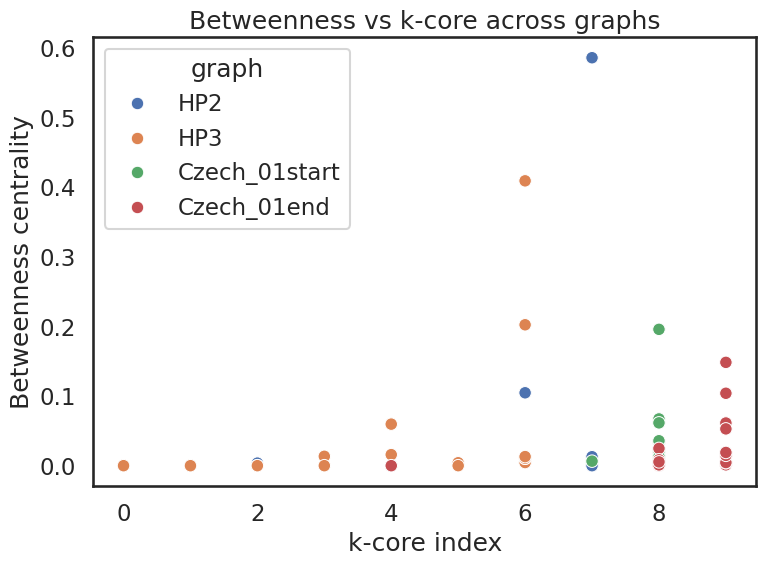

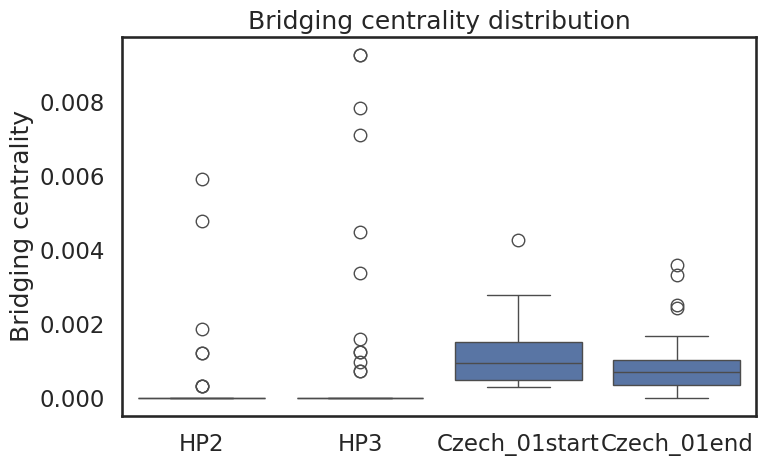

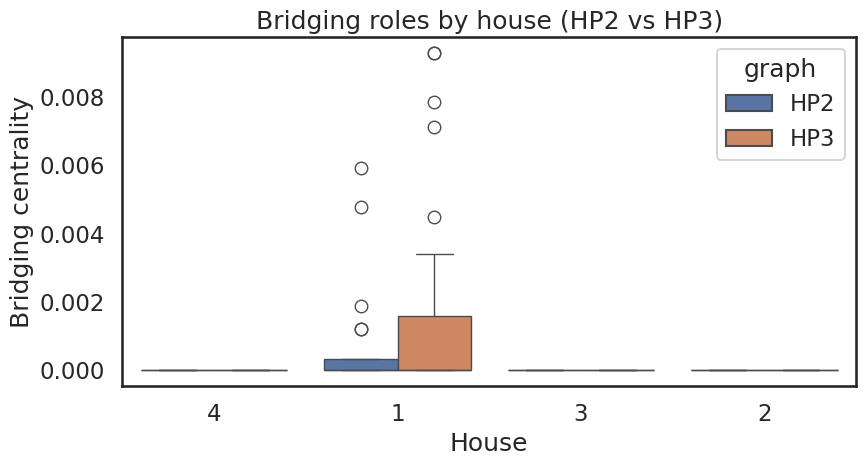

In [18]:
# Cell 16: Plots for structural holes
# 16a. Betweenness vs k-core by graph
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_nodes_all,
    x="kcore",
    y="betweenness",
    hue="graph",
)
plt.ylabel("Betweenness centrality")
plt.xlabel("k-core index")
plt.title("Betweenness vs k-core across graphs")
plt.tight_layout()
plt.show()

# 16b. Bridging centrality distribution by graph
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_nodes_all,
    x="graph",
    y="bridging_centrality",
)
plt.ylabel("Bridging centrality")
plt.xlabel("")
plt.title("Bridging centrality distribution")
plt.tight_layout()
plt.show()

# 16c. Bridging centrality by house (HP only)
df_hp_bridge = df_nodes_all[
    df_nodes_all["graph"].isin(["HP2", "HP3"])
].dropna(subset=["house"])

plt.figure(figsize=(9, 5))
sns.boxplot(
    data=df_hp_bridge,
    x="house",
    y="bridging_centrality",
    hue="graph",
)
plt.ylabel("Bridging centrality")
plt.xlabel("House")
plt.title("Bridging roles by house (HP2 vs HP3)")
plt.tight_layout()
plt.show()


In [19]:
# Cell 17: New edge diagnostics (reciprocity and triadic closure)
def edge_set(G):
    return set(G.edges())

def new_edge_diagnostics(G_start, G_end, label):
    """
    For edges that appear in G_end but not in G_start, compute:
      - fraction that are reciprocal with respect to G_start
      - fraction that close at least one triangle using G_start's undirected structure
    """
    E1 = edge_set(G_start)
    E2 = edge_set(G_end)
    new_edges = list(E2 - E1)
    if not new_edges:
        return pd.DataFrame([{
            "pair": label,
            "n_new_edges": 0,
            "frac_new_reciprocal": np.nan,
            "frac_new_closing_triangles": np.nan,
        }])

    G_und_start = G_start.to_undirected()
    neighbors_start = {v: set(G_und_start.neighbors(v)) for v in G_und_start.nodes()}

    reciprocal_flags = []
    triad_flags = []

    for i, j in new_edges:
        reciprocal_flags.append((j, i) in E1)

        neigh_i = neighbors_start.get(i, set())
        neigh_j = neighbors_start.get(j, set())
        closing = len(neigh_i & neigh_j) > 0
        triad_flags.append(closing)

    return pd.DataFrame([{
        "pair": label,
        "n_new_edges": len(new_edges),
        "frac_new_reciprocal": np.mean(reciprocal_flags),
        "frac_new_closing_triangles": np.mean(triad_flags),
    }])

diag_hp = new_edge_diagnostics(HP2, HP3, "HP2→HP3")
diag_cz = new_edge_diagnostics(G_cz_start, G_cz_end, "Czech 01start→01end")

df_new_edge_diag = pd.concat([diag_hp, diag_cz], ignore_index=True)
df_new_edge_diag


,pair,n_new_edges,frac_new_reciprocal,frac_new_closing_triangles
0,HP2→HP3,25,0.28,0.64
1,Czech 01start→01end,80,0.40,1.00


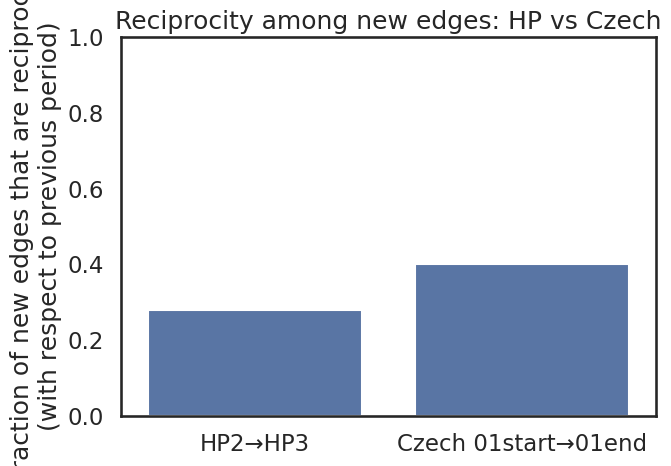

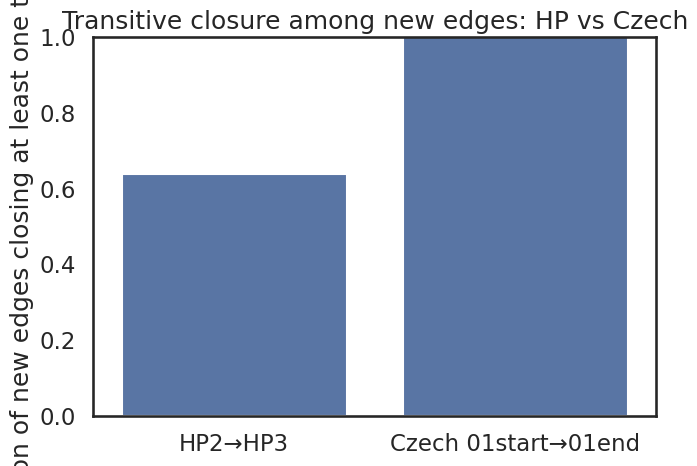

In [20]:
# Cell 18: Plots for new-edge reciprocity and triadic closure
plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_new_edge_diag,
    x="pair",
    y="frac_new_reciprocal",
)
plt.ylabel("Fraction of new edges that are reciprocal\n(with respect to previous period)")
plt.xlabel("")
plt.title("Reciprocity among new edges: HP vs Czech")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_new_edge_diag,
    x="pair",
    y="frac_new_closing_triangles",
)
plt.ylabel("Fraction of new edges closing at least one triangle")
plt.xlabel("")
plt.title("Transitive closure among new edges: HP vs Czech")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [21]:
# Cell 19: Degree centralization
def degree_centralization(G, directed=True):
    """
    Freeman outdegree centralization, normalized by its maximum for a star graph.
    """
    if directed and isinstance(G, nx.DiGraph):
        deg = dict(G.out_degree())
    else:
        deg = dict(G.degree())
    n = len(deg)
    if n <= 2:
        return np.nan
    max_deg = max(deg.values())
    sum_diff = sum(max_deg - d for d in deg.values())
    max_c = (n - 1) * (n - 2)  # star graph
    return sum_diff / max_c if max_c > 0 else np.nan

df_centralization = pd.DataFrame([
    {"graph": "HP2",          "outdegree_centralization": degree_centralization(HP2, directed=True)},
    {"graph": "HP3",          "outdegree_centralization": degree_centralization(HP3, directed=True)},
    {"graph": "Czech_01start","outdegree_centralization": degree_centralization(G_cz_start, directed=True)},
    {"graph": "Czech_01end",  "outdegree_centralization": degree_centralization(G_cz_end, directed=True)},
])
df_centralization


,graph,outdegree_centralization
0,HP2,0.124168
1,HP3,0.141577
2,Czech_01start,0.584980
3,Czech_01end,0.480237


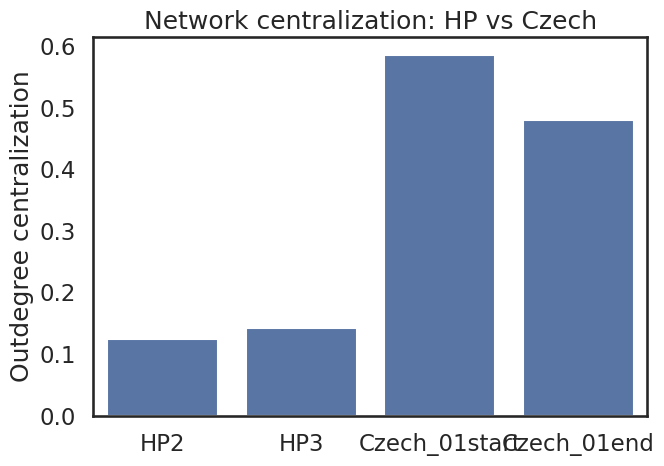

In [22]:
# Cell 20: Plot network centralization
plt.figure(figsize=(7, 5))
sns.barplot(
    data=df_centralization,
    x="graph",
    y="outdegree_centralization",
)
plt.ylabel("Outdegree centralization")
plt.xlabel("")
plt.title("Network centralization: HP vs Czech")
plt.tight_layout()
plt.show()
